In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
from pathlib import Path
import torchvision
import seaborn as sns
from random import sample
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class SpectrogramDataset(Dataset):
    def __init__(self, spectro_folder):
        self.spectrogram_folders = list(spectro_folder.glob('spectrogram_*'))
        self.transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            # transforms.Lambda(lambda x: torch.flatten(x)),
        ])

    def __len__(self):
        return len(self.spectrogram_folders)

    def __getitem__(self, idx):
        folder_path = self.spectrogram_folders[idx]

        # Load the spectrogram image
        img = Image.open(folder_path / 'spectrogram.png')#.convert('L')
        img = self.transform(img)

        # Load the label
        label_path = folder_path / 'label.txt'
        with open(label_path, 'r') as label_file:
            label = int(label_file.read().strip())

        return img, label

# Path to the folder containing your spectrograms
spectro_folder = Path('./spectrograms')

# Create a custom dataset
Data = SpectrogramDataset(spectro_folder)
# dataloader = DataLoader(Data, batch_size = len(Data))
unique_labels = set()

for _, label in Data:
    unique_labels.add(label)

class_indices = {label: [] for label in unique_labels}

for idx in range(len(Data)):
    _, label = Data[idx]
    class_indices[label].append(idx)

selected_indices = []
for label, indices in class_indices.items():
    if len(indices) >= 100:
        selected_indices.extend(sample(indices, 100))
    else:
        selected_indices.extend(indices)
        print(f"Not enough data in class {label}, only {len(indices)} available.")

subset_dataset = Subset(Data, selected_indices)

subset_dataloader = DataLoader(subset_dataset, batch_size=len(subset_dataset), shuffle=True)  # Adjust batch size as needed
# dataloader = DataLoader(Data, batch_size = len(Data))

print(len(subset_dataset))

Not enough data in class 4, only 53 available.
453


In [3]:
# for batch_idx, (images, labels) in enumerate(dataloader):
# #     print(f"Training SVM for batch {batch_idx + 1}/{len(subs)}...")
#     images = np.asarray(images)
#     labels = np.asarray(labels)

#     x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)
    
#     classifier = SVC(probability=True, decision_function_shape='ovr')

#     param_grid={'C':[0.01, 0.1, 1, 10, 100],
#             'gamma':[0.01, 0.1, 1, 10, 100],
#             'degree': [2, 3],
#             'kernel':['poly', 'rbf', 'linear']}

#     model = GridSearchCV(classifier, param_grid)

#     model.fit(x_train, y_train)

#     best_model = model.best_estimator_
#     print("Best model parameters:")
#     print(best_model.get_params())


#     # Evaluate the final model
#     y_pred = best_model.predict(x_test)
#     print(f"The model is {accuracy_score(y_pred, y_test) * 100}% accurate")

In [3]:
for batch_idx, (images, labels) in enumerate(subset_dataloader):
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)
    print(x_train.shape)
    %store x_test
    %store y_test

torch.Size([362, 4, 227, 227])
Stored 'x_test' (Tensor)
Stored 'y_test' (Tensor)


In [4]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

model = SVC(probability=True, decision_function_shape='ovr')

param_distributions = {'C': [0.01, 0.1, 1, 10, 100],
                        'gamma': [0.01, 0.1, 1, 10, 100],
                        'degree': [2, 3, 4, 5, 6],
                        'kernel': ['poly', 'rbf', 'linear']}

rnd_search = RandomizedSearchCV(model, param_distributions, n_iter=5, cv=5, verbose=2, random_state=42)
rnd_search.fit(x_train, y_train)

best_model = rnd_search.best_estimator_
print("Best model parameters:")
print(best_model.get_params())

# Evaluate the final model
y_pred = best_model.predict(x_test)
print(f"The model is {accuracy_score(y_test, y_pred) * 100}% accurate")

# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, images, labels, cv=5,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve for SVM")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...........C=1, degree=3, gamma=0.01, kernel=linear; total time= 1.0min
[CV] END ...........C=1, degree=3, gamma=0.01, kernel=linear; total time= 1.0min
[CV] END ...........C=1, degree=3, gamma=0.01, kernel=linear; total time= 1.0min
[CV] END ...........C=1, degree=3, gamma=0.01, kernel=linear; total time= 1.0min
[CV] END ...........C=1, degree=3, gamma=0.01, kernel=linear; total time=  59.6s
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time= 1.0min
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time= 1.0min
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time= 1.0min
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time= 1.0min
[CV] END ...........C=0.01, degree=4, gamma=0.1, kernel=poly; total time= 1.0min
[CV] END ..........C=0.01, degree=3, gamma=0.01, kernel=poly; total time= 1.0min


In [2]:
for batch_idx, (images, labels) in enumerate(subset_dataloader):
    # images = np.asarray(images)
    # labels = np.asarray(labels)
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)
    %store x_test
    %store y_test
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    
    model = SVC(probability=True, decision_function_shape='ovr')

    param_distributions = {'C': [0.01, 0.1, 1, 10, 100],
                           'gamma': [0.01, 0.1, 1, 10, 100],
                           'degree': [2, 3, 4, 5, 6],
                           'kernel': ['poly', 'rbf', 'linear']}
    
    rnd_search = RandomizedSearchCV(model, param_distributions, n_iter=5, cv=5, verbose=2, random_state=42)
    rnd_search.fit(x_train, y_train)

    best_model = rnd_search.best_estimator_
    print("Best model parameters:")
    print(best_model.get_params())

    # Evaluate the final model
    y_pred = best_model.predict(x_test)
    print(f"The model is {accuracy_score(y_test, y_pred) * 100}% accurate")

    # Plot learning curve
    train_sizes, train_scores, test_scores = learning_curve(best_model, images, labels, cv=5,
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title("Learning Curve for SVM")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

Stored 'x_test' (Tensor)
Stored 'y_test' (Tensor)
Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [14]:

print(classification_report(y_test, y_pred, target_names=['sleep stage W', 'sleep Stage 1', 'sleep Stage 2', 'Sleep Stage 3/4', 'Sleep Stage R']))

                 precision    recall  f1-score   support

  sleep stage W       0.52      0.65      0.58        20
  sleep Stage 1       0.44      0.35      0.39        20
  sleep Stage 2       0.65      0.55      0.59        20
Sleep Stage 3/4       0.64      0.82      0.72        11
  Sleep Stage R       0.42      0.40      0.41        20

       accuracy                           0.53        91
      macro avg       0.53      0.55      0.54        91
   weighted avg       0.52      0.53      0.52        91



In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=0.8)
# pca.fit(x_train)
# # print(pca.explained_variance_ratio_)
# fig, axes = plt.subplots(2,10,figsize=(9,3),
#  subplot_kw={'xticks':[], 'yticks':[]},
#  gridspec_kw=dict(hspace=0.01, wspace=0.01))
# for i, ax in enumerate(axes.flat):
#  ax.imshow(pca.components_[i].reshape(64,64),cmap='gray')
# converted_data = pca.fit_transform(x_train)

In [ ]:
# plt.figure(figsize = (10,6))
# c_map = plt.cm.get_cmap('jet', 10)
# plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 50,
#             cmap = c_map , c = y_train)
# plt.colorbar()
# plt.xlabel('PC-1') , plt.ylabel('PC-2')
# plt.show()

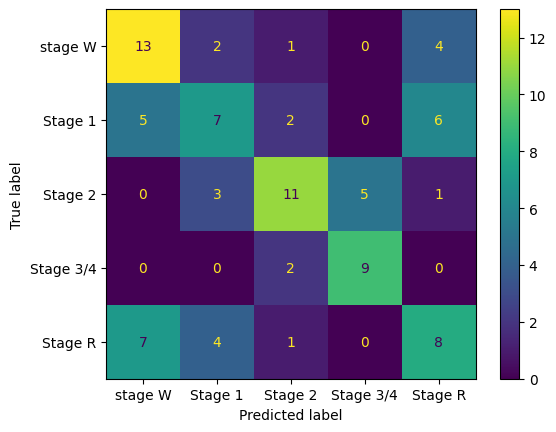

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["stage W", "Stage 1", "Stage 2", "Stage 3/4", "Stage R"])
disp.plot()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

3.2637362637362637

In [18]:
%store x_test
%store y_test

Stored 'x_test' (ndarray)
Stored 'y_test' (ndarray)
